## User Behaviour on Twitter
Unsupervised clustering and interpreting.

In [63]:
#import libs
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import  tqdm #NOT NEEDED, JUST USED WHEN WRITING THE NOTEBOOK
pd.set_option('display.max_columns', None)
from collections import Counter

In [2]:
#loading
egoalter = pd.read_csv('./EgoAlterProfiles.txt',delimiter='\t')
#egonet = pd.read_csv('./EgoNetworks.txt',delimiter='\t')
egotimes = pd.read_csv('./EgoTimelines.txt',delimiter='\t',encoding='latin-1')

In [3]:
egoalter.head()

,ID,IsEgo,followers_count,friends_count,statuses_count,utc_offset,lang,created_at,protected
0,1,True,30.0,28,9.0,NaN,en,Wed Oct 26 03:30:32 +0000 2011,False
1,2,True,2.0,8,7.0,-14400.0,en,Mon Jul 27 20:46:32 +0000 2009,False
2,3,True,1.0,0,0.0,NaN,fr,Mon Apr 23 20:57:26 +0000 2012,False
3,4,True,3.0,3,68.0,NaN,en,Sun Feb 14 07:50:39 +0000 2010,False
4,5,True,65.0,118,748.0,NaN,fr,Mon Jun 11 14:17:06 +0000 2012,False


In [4]:
egotimes[200:400]

,replyto_userid,retweeted_userid,id,tweetid,created_at,hashtags,urls,mentions_ids,retweet_count,egoID,retweetedUserID,replytoUserID,metionID
200,NaN,NaN,605458456,523333693134622720,Sat Oct 18 04:44:10 +0000 2014,NaN,NaN,131556965,0,5,NaN,NaN,2423603
201,NaN,162670016.0,605458456,413801463979458560,Thu Dec 19 22:42:11 +0000 2013,NaN,NaN,"162670016,424891673,324662307",5,5,NaN,NaN,1792569
202,NaN,NaN,605458456,527763081762717696,Thu Oct 30 10:04:58 +0000 2014,IciCestParis,NaN,NaN,0,5,NaN,NaN,NaN
203,NaN,NaN,605458456,527719935527878656,Thu Oct 30 07:13:31 +0000 2014,NaN,NaN,NaN,0,5,NaN,NaN,NaN
204,NaN,NaN,605458456,527252905972494338,Wed Oct 29 00:17:43 +0000 2014,NaN,NaN,NaN,0,5,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,NaN,NaN,605458456,424146092771778560,Fri Jan 17 11:48:03 +0000 2014,NaN,NaN,NaN,0,5,NaN,NaN,NaN
396,NaN,NaN,605458456,394447458828161025,Sun Oct 27 12:56:17 +0000 2013,skyrim,NaN,NaN,0,5,NaN,NaN,NaN
397,NaN,NaN,605458456,347778837368684544,Thu Jun 20 18:11:50 +0000 2013,NaN,http://t.co/n3Am0xdPgI,NaN,0,5,NaN,NaN,NaN
398,NaN,NaN,605458456,322070627999707136,Wed Apr 10 19:36:36 +0000 2013,BARCAPSG,NaN,NaN,0,5,NaN,NaN,NaN


### Features used for clustering
- followers count
- friends count
- followers-friends ratio
- proportion of tweets
- proportion of RT
- proportion of replies
- days since account creation
- average number of statuses per month
- average number of hashtags per post
- average number of URLs per post
- average number of mentions per post
- average number of retweets per tweet

In [5]:
def extract_info(df):
    
    n = len(df)
    n_replies = n - np.sum(df['replyto_userid'].isnull())
    n_rt = n - np.sum(df['retweeted_userid'].isnull())
    mentions = df[df['mentions_ids'].notnull()].mentions_ids
    n_mentions = len([x for xs in mentions for x in xs.split(',')])
    
    retweeted = np.nansum(df['retweet_count'])
    
    # number of hashtags
    hashtags = df[df['hashtags'].notnull()].hashtags
    n_hashtags = len([x for xs in hashtags for x in xs.split(',')])
    
    # number of urls per tweet
    urls = df[df['urls'].notnull()].urls
    n_urls = len([x for xs in urls for x in xs.split(',')])
    
    return n, n_replies, n_mentions, n_rt, n_hashtags, n_urls, retweeted

In [6]:
isEgo = egoalter.loc[egoalter['IsEgo']]

In [7]:
ego_intersect = set(egotimes['egoID'].unique()).intersection(set(isEgo['ID']))
columns = ['id','n_statuses', 'n_replies','n_mentions','n_rt','n_hashtags','n_urls','retweeted']
stats = pd.DataFrame(0, index=np.arange(len(ego_intersect)), columns=columns)

for i, _id in tqdm(enumerate(ego_intersect)):
    n, n_replies, n_mentions, n_rt, n_hashtags, n_urls, retweeted = extract_info(egotimes.loc[egotimes['egoID']==_id])
    stats.iloc[i].id = _id
    stats.iloc[i].n_statuses = n
    stats.iloc[i].n_replies = n_replies
    stats.iloc[i].n_mentions = n_mentions
    stats.iloc[i].n_rt = n_rt
    stats.iloc[i].n_hashtags = n_hashtags
    stats.iloc[i].n_urls = n_urls
    stats.iloc[i].retweeted = retweeted

17244it [03:55, 73.15it/s]


In [8]:
merged = isEgo.merge(stats, how='left', left_on='ID', right_on='id')
merged.head()

,ID,IsEgo,followers_count,friends_count,statuses_count,utc_offset,lang,created_at,protected,id,n_statuses,n_replies,n_mentions,n_rt,n_hashtags,n_urls,retweeted
0,1,True,30.0,28,9.0,NaN,en,Wed Oct 26 03:30:32 +0000 2011,False,1.0,9.0,4.0,8.0,0.0,0.0,0.0,0.0
1,2,True,2.0,8,7.0,-14400.0,en,Mon Jul 27 20:46:32 +0000 2009,False,2.0,7.0,2.0,2.0,0.0,1.0,3.0,0.0
2,3,True,1.0,0,0.0,NaN,fr,Mon Apr 23 20:57:26 +0000 2012,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,True,3.0,3,68.0,NaN,en,Sun Feb 14 07:50:39 +0000 2010,False,4.0,68.0,0.0,0.0,0.0,0.0,60.0,0.0
4,5,True,65.0,118,748.0,NaN,fr,Mon Jun 11 14:17:06 +0000 2012,False,5.0,742.0,334.0,375.0,103.0,118.0,29.0,26408.0


In [9]:
inactive = (merged.friends_count == 0) & (merged.followers_count == 0)
merged['followers_ratio'] = (merged['followers_count']/(merged['friends_count'] + 0.01))
merged.loc[inactive,'followers_ratio'] = 1

merged['n_tweets'] = merged['n_statuses'] - merged['n_replies'] - merged['n_rt']
merged['prop_tweets'] = merged['n_tweets']/merged['n_statuses']
merged['prop_replies'] = merged['n_replies']/merged['n_statuses']
merged['prop_rt'] = merged['n_rt']/merged['n_statuses']
merged['avg_hashtags'] = merged['n_hashtags']/merged['n_statuses']
merged['avg_urls'] = merged['n_urls']/merged['n_statuses']
merged['avg_mentions'] = merged['n_mentions']/merged['n_statuses']
merged['avg_retweeted'] = (merged['retweeted']/merged['n_tweets']).replace(np.inf, 0)
merged['created_at'] = pd.to_datetime(merged['created_at'], format='%a %b %d %H:%M:%S %z %Y')
end_date = merged.created_at.max()
merged['account_age_months'] = ((end_date - merged.created_at).dt.days/30) + 0.01
merged['statuses_per_month'] = merged['statuses_count']/merged['account_age_months']
merged.head()

,ID,IsEgo,followers_count,friends_count,statuses_count,utc_offset,lang,created_at,protected,id,n_statuses,n_replies,n_mentions,n_rt,n_hashtags,n_urls,retweeted,followers_ratio,n_tweets,prop_tweets,prop_replies,prop_rt,avg_hashtags,avg_urls,avg_mentions,avg_retweeted,account_age_months,statuses_per_month
0,1,True,30.0,28,9.0,NaN,en,2011-10-26 03:30:32+00:00,False,1.0,9.0,4.0,8.0,0.0,0.0,0.0,0.0,1.071046,5.0,0.555556,0.444444,0.000000,0.000000,0.000000,0.888889,0.000000,36.676667,0.245388
1,2,True,2.0,8,7.0,-14400.0,en,2009-07-27 20:46:32+00:00,False,2.0,7.0,2.0,2.0,0.0,1.0,3.0,0.0,0.249688,5.0,0.714286,0.285714,0.000000,0.142857,0.428571,0.285714,0.000000,64.010000,0.109358
2,3,True,1.0,0,0.0,NaN,fr,2012-04-23 20:57:26+00:00,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.643333,0.000000
3,4,True,3.0,3,68.0,NaN,en,2010-02-14 07:50:39+00:00,False,4.0,68.0,0.0,0.0,0.0,0.0,60.0,0.0,0.996678,68.0,1.000000,0.000000,0.000000,0.000000,0.882353,0.000000,0.000000,57.310000,1.186529
4,5,True,65.0,118,748.0,NaN,fr,2012-06-11 14:17:06+00:00,False,5.0,742.0,334.0,375.0,103.0,118.0,29.0,26408.0,0.550801,305.0,0.411051,0.450135,0.138814,0.159030,0.039084,0.505391,86.583607,29.010000,25.784212


In [10]:
cols = ['followers_count','friends_count','statuses_count', 'account_age_months',
        'statuses_per_month','followers_ratio','prop_tweets', 'prop_replies','prop_rt',
        'avg_hashtags','avg_urls','avg_mentions']
features = merged[cols].fillna(0)

In [41]:
features.set_index('ID').describe()

,followers_count,friends_count,statuses_count,account_age_months,statuses_per_month,followers_ratio,prop_tweets,prop_replies,prop_rt,avg_hashtags,avg_urls,avg_mentions
count,34006.000000,34006.000000,3.400600e+04,34006.000000,34006.000000,34006.000000,34006.000000,34006.000000,34006.000000,34006.000000,34006.000000,34006.000000
mean,56.604511,68.490061,4.483272e+02,26.648642,16.856397,39.142005,0.323153,0.115620,0.068313,0.094698,0.096359,0.249363
std,953.436514,344.940809,6.748816e+03,18.094187,174.167148,1879.330302,0.410767,0.245612,0.189213,0.330004,0.256844,0.448269
min,0.000000,0.000000,0.000000e+00,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000e+00,11.643333,0.000000,0.052604,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,8.000000,1.000000e+00,23.876667,0.035150,0.363306,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8.000000,37.000000,1.100000e+01,39.043333,0.671855,1.000000,0.727273,0.067467,0.000000,0.000000,0.001258,0.422831
max,124195.000000,24956.000000,1.082327e+06,104.476667,22893.471057,253800.000000,1.000000,1.000000,1.000000,12.000000,4.000000,8.500000


### To do: feature scaling and clustering

In [11]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
df = ((features-features.min())/(features.max()-features.min()))*20

In [14]:
epses = [0.1, 1., 3., 5., 10., 20.]
min_samples = [5, 10, 50, 100, 500]
for eps in epses:
    for min_sample in min_samples: 
        dbscan = DBSCAN(eps=eps, min_samples=min_sample).fit(df)
        unique_labels = set(dbscan.labels_)
        try:
            sl = silhouette_score(df, dbscan.labels_)
        except:
            sl = -1.
        print(eps, min_sample, sl)

0.1 5 -0.46034120534238787
0.1 10 0.16886379875531604
0.1 50 0.28265100368423485
0.1 100 0.24079656323485768
0.1 500 -1.0
1.0 5 0.03535248806766365
1.0 10 0.0900939460406576
1.0 50 0.3205139971827859
1.0 100 0.38417014549928535
1.0 500 0.3338121016592919
3.0 5 0.45799471482773924
3.0 10 0.48774874187270645
3.0 50 0.4905940741986209
3.0 100 0.4876655497201395
3.0 500 0.4831279594713284
5.0 5 0.49043510609621216
5.0 10 0.4904529587511421
5.0 50 0.4906015475652597
5.0 100 0.4906637385523208
5.0 500 0.48491995865092996
10.0 5 0.4903578187281798
10.0 10 0.4903578187281798
10.0 50 0.4903802251235645
10.0 100 0.4903802251235645
10.0 500 0.4904010380853822
20.0 5 0.5751583300678177
20.0 10 0.5751583300678177
20.0 50 0.5751583300678177
20.0 100 0.5751583300678177
20.0 500 0.5751583300678177


In [ ]:
from sklearn.metrics import silhouette_score
epses = [20., 200.]
min_samples = [500, 5000]
for eps in epses:
    for min_sample in min_samples: 
        dbscan = DBSCAN(eps=eps, min_samples=min_sample).fit(df)
        unique_labels = set(dbscan.labels_)
        sl = silhouette_score(df, dbscan.labels_)
        print(eps, min_sample, sl)

20.0 500 0.5751583300678177
20.0 5000 0.5751583300678177


In [24]:
def find_average_user(X, labels):
    uniq_labels = sorted(list(set(labels)))
    average_users = []
    average_labels = []
    for label in uniq_labels:
        inds = [labels == label]
        inds = inds[0]
        cluster_users = X.iloc[inds]
        if len(cluster_users) > 100:
            average_user = cluster_users.mean(axis=0)
            average_users.append(average_user)
            average_labels.append(label)
    return dict(zip(average_labels, average_users))

## DBSCAN

In [64]:
from sklearn.metrics import silhouette_score
eps = 1.
min_sample = 100
dbscan = DBSCAN(eps=eps, min_samples=min_sample).fit(df)
unique_labels = set(dbscan.labels_)
sl = 0. #silhouette_score(df, dbscan.labels_)
print(eps, min_sample, len(unique_labels), sl)
print(Counter(dbscan.labels_))

1.0 100 5 0.0
Counter({0: 16736, -1: 11306, 1: 4408, 3: 804, 2: 752})


In [65]:
unique_labels = set(dbscan.labels_)
unique_colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
color_dict = dict(zip(unique_labels, unique_colors))
labels = dbscan.labels_
colors = []
for label in labels:
    colors.append(color_dict[label])
print(unique_labels)

{0, 1, 2, 3, -1}


In [75]:
users = find_average_user(df, dbscan.labels_)
users_list = []
for k, v in users.items():
    users_list.append(v.values)
users_list = np.array(users_list)
users_list[:, 1]

array([0.1286804 , 0.01552125, 0.0265889 , 0.02821135, 0.01679174])

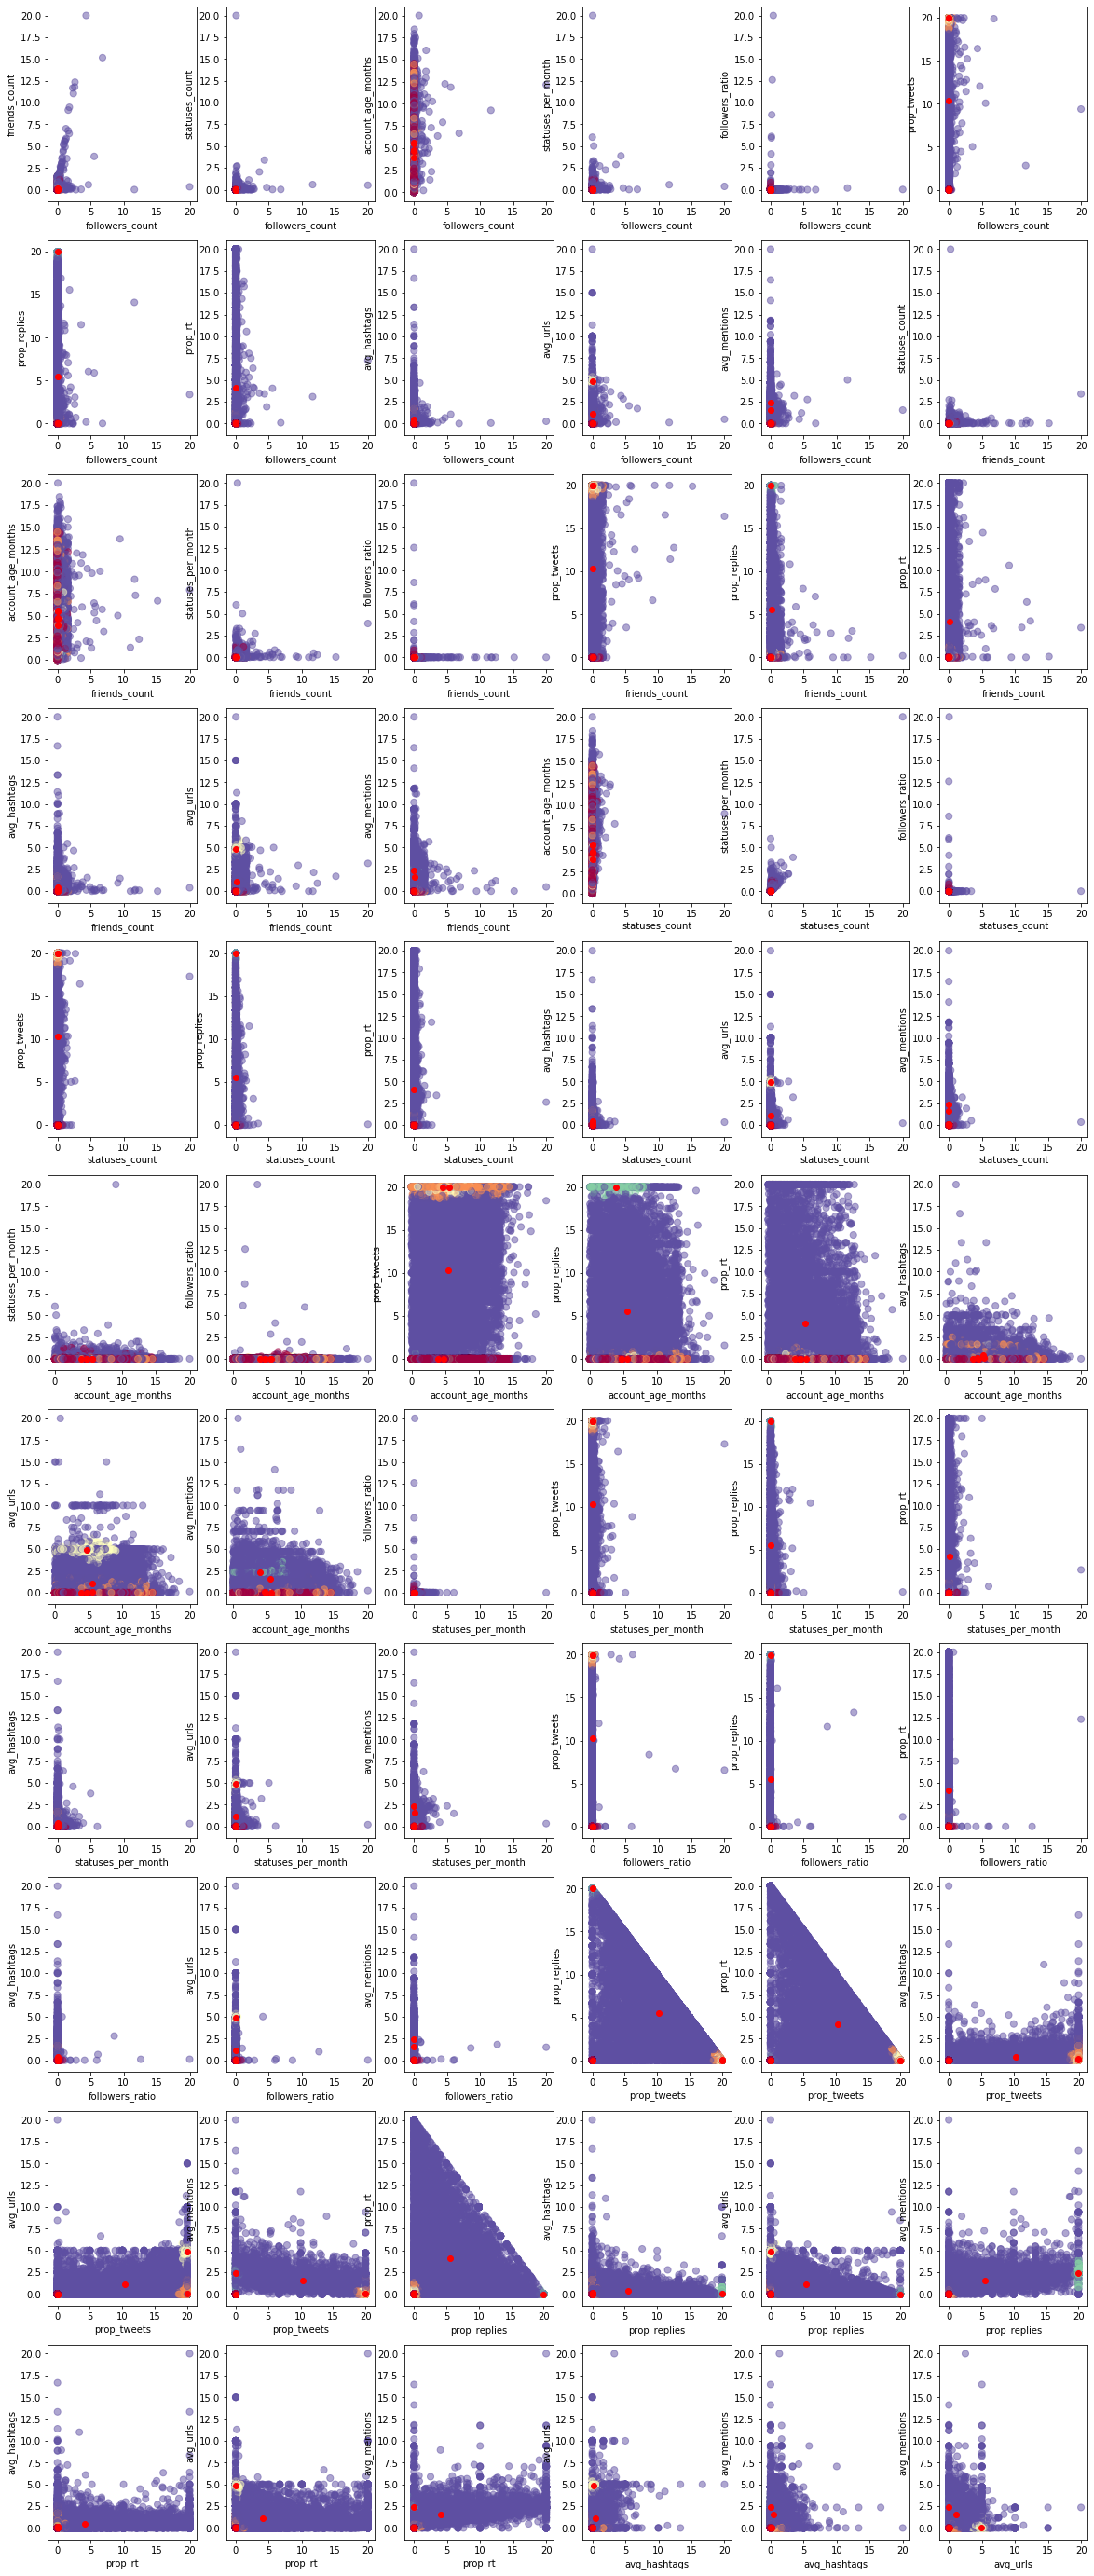

In [76]:
users = find_average_user(df, dbscan.labels_)

fig, ax_arr = plt.subplots(11, 6, figsize=(20, 50))
ax_arr = np.array(ax_arr).ravel()

k = 0
for i in range(len(cols) - 1):
    for j in range(i + 1, len(cols)):
        ax = ax_arr[k]
        k += 1
        #ax.scatter(df[cols[i]], df[cols[j]], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
        ax.scatter(df[cols[i]], df[cols[j]], c=colors, s=50, alpha=0.5)
        ax.set_xlabel(cols[i])
        ax.set_ylabel(cols[j])
        ax.scatter(users_list[:, i], users_list[:, j], c='red')
        #for k, v in users.items():
        #    ax.scatter(v[i], v[j], color='red')
            #ax.annotate('dot ' + str(k), (new_average_vector[0], new_average_vector[1]), c='black')

In [77]:
print(users)

{-1: followers_count        0.024655
friends_count          0.128680
statuses_count         0.021889
account_age_months     5.489455
statuses_per_month     0.038183
followers_ratio        0.006667
prop_tweets           10.322961
prop_replies           5.526045
prop_rt                4.105001
avg_hashtags           0.423444
avg_urls               1.101868
avg_mentions           1.580651
dtype: float64, 0: followers_count       0.001171
friends_count         0.015521
statuses_count        0.001703
account_age_months    4.777385
statuses_per_month    0.003241
followers_ratio       0.001339
prop_tweets           0.000000
prop_replies          0.000000
prop_rt               0.000000
avg_hashtags          0.000000
avg_urls              0.000000
avg_mentions          0.000000
dtype: float64, 1: followers_count        0.002173
friends_count          0.026589
statuses_count         0.000750
account_age_months     5.611802
statuses_per_month     0.002155
followers_ratio        0.001252
prop_twee

Interpretation:
0. Incognito
1. Many tweets, small amount of everything else, so content generation
2. The same as 1, but many urls, so advertisment 
3. Social, many replys and mentions (celebrity)
-1. Active user, many everything

## KMEANS

[[ 1.06697008e-02  6.47532878e-02  7.87523875e-03  5.60104439e+00
   1.26146609e-02  2.99969340e-03  1.93196056e+01  3.77381030e-01
   3.03013328e-01  2.96350751e-01  1.30529657e+00  3.19147629e-01]
 [ 3.06737605e-02  1.42698517e-01  2.88993104e-02  5.97363850e+00
   4.36022844e-02  2.44280356e-03  1.07447594e+01  6.53901732e+00
   2.71622325e+00  3.00047007e-01  6.18091562e-01  1.42121307e+00]
 [ 1.49691874e-03  1.71260517e-02  3.85279783e-03  8.48952787e+00
   3.84144523e-03  4.59112529e-03  7.14983628e-13  9.94759830e-14
   7.86037901e-14  1.69864123e-14  5.00155473e-14  9.69224700e-14]
 [ 1.69329973e-02  1.50431574e-01  1.93180609e-02  4.10404524e+00
   5.19803333e-02  1.04950214e-02  3.40210948e+00  1.99757467e+00
   1.46003159e+01  6.06690848e-01  1.08559658e+00  2.44928827e+00]
 [ 1.22711783e-02  5.10506086e-02  5.64229822e-03  4.78841191e+00
   1.35343400e-02  5.74991227e-03  2.27364469e+00  1.68221549e+01
   9.04200368e-01  1.42180762e-01  2.61944996e-01  2.39439741e+00]
 [ 1.

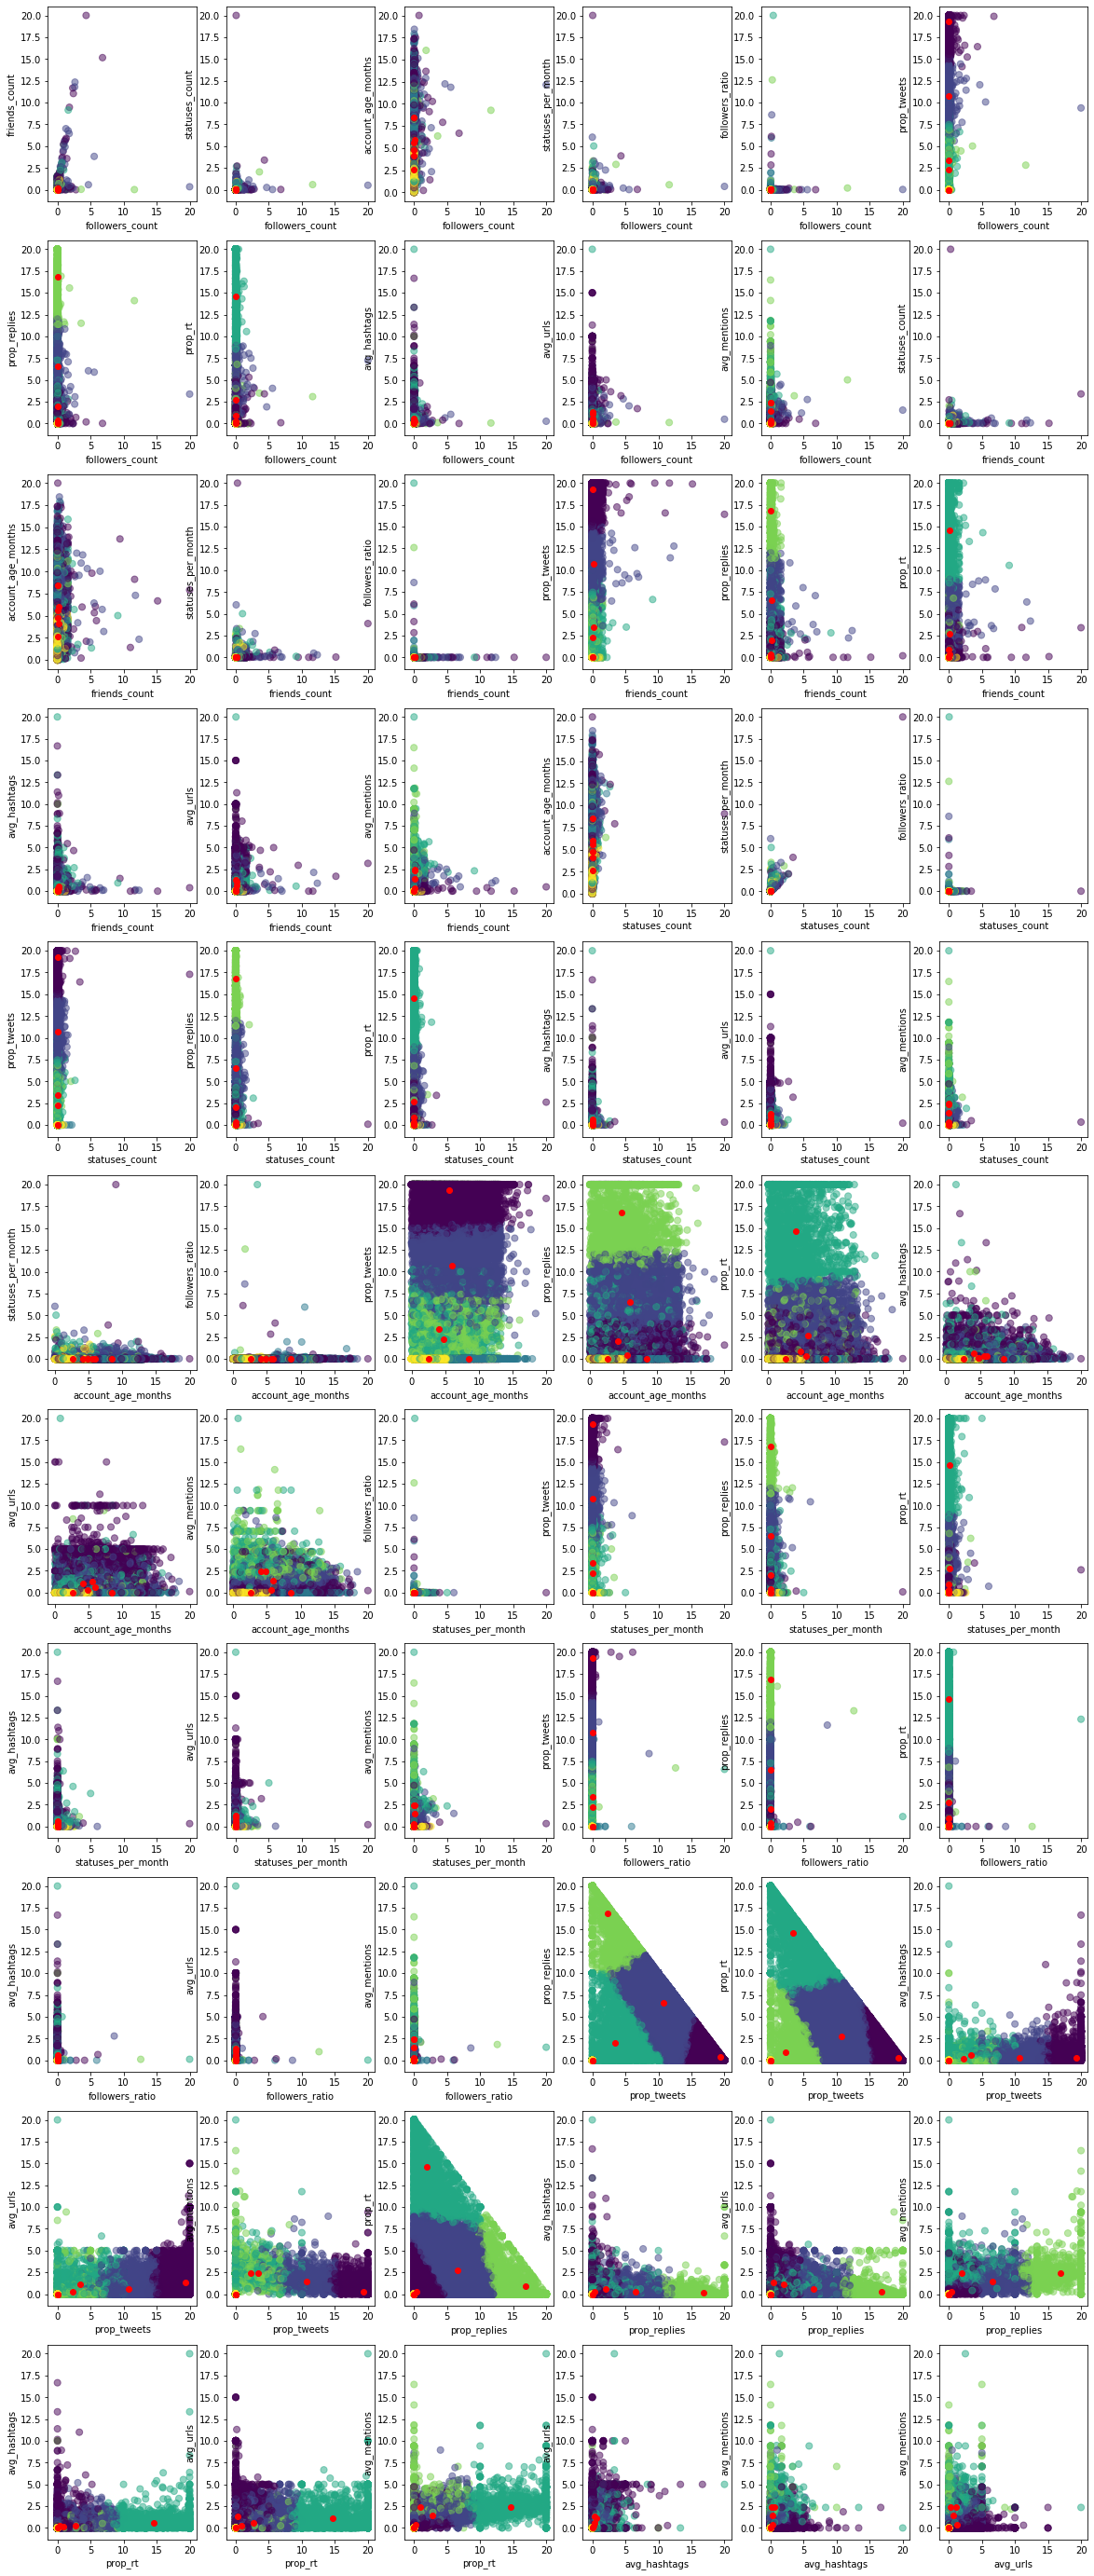

In [78]:
kmeans = KMeans(n_clusters=6).fit(df)
centroids = kmeans.cluster_centers_
print(centroids)
users = find_average_user(df, kmeans.labels_)
users_list = []
for k, v in users.items():
    users_list.append(v.values)
users_list = np.array(users_list)

#dbscan = DBSCAN(eps=eps, min_samples=min_sample).fit(df)

fig, ax_arr = plt.subplots(11, 6, figsize=(20, 50))
ax_arr = np.array(ax_arr).ravel()

k = 0
for i in range(len(cols) - 1):
    for j in range(i + 1, len(cols)):
        ax = ax_arr[k]
        k += 1
        ax.scatter(df[cols[i]], df[cols[j]], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
        #ax.scatter(df[cols[i]], df[cols[j]], c=colors, s=50, alpha=0.5)
        ax.set_xlabel(cols[i])
        ax.set_ylabel(cols[j])
        ax.scatter(users_list[:, i], users_list[:, j], c='red')

In [79]:
find_average_user(df, kmeans.labels_)

{0: followers_count        0.010670
 friends_count          0.064756
 statuses_count         0.007890
 account_age_months     5.601436
 statuses_per_month     0.012624
 followers_ratio        0.002999
 prop_tweets           19.317810
 prop_replies           0.377712
 prop_rt                0.304478
 avg_hashtags           0.296285
 avg_urls               1.304987
 avg_mentions           0.319406
 dtype: float64,
 1: followers_count        0.030660
 friends_count          0.142636
 statuses_count         0.028864
 account_age_months     5.972626
 statuses_per_month     0.043574
 followers_ratio        0.002442
 prop_tweets           10.737110
 prop_replies           6.546485
 prop_rt                2.716404
 avg_hashtags           0.300092
 avg_urls               0.617822
 avg_mentions           1.421581
 dtype: float64,
 2: followers_count       0.001497
 friends_count         0.017126
 statuses_count        0.003853
 account_age_months    8.489528
 statuses_per_month    0.003841
 foll

Interpretations:
2 and 5 -- pretty much the same (low tweets, low retweets etc), but 5 has much smaller time of account existance, sp \\
2 --  Incognito  \\
5 -- Bot account or account to collect infos
4 -- Social, many replies and mentions, so active celebrity or active user.
3 -- Mentions, url and many retweets, not much tweets, big followers_ratio, advertisment or movies/albums accounts.
1 -- Active popular users, big amount of tweets, mentions retweets, generate and share the content
0 -- Content generation, big tweets, small amount of anything else.
